<a href="https://colab.research.google.com/github/pjs102793/gachon_edu/blob/main/Fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# nvcc version 확인
!nvcc -V
# GCC version 확인
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# MMDetection에 필요한 종속성 설치
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.8/449.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 30.6 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 10.4 MB/s eta 0:00:00


### 런타임 다시 시작

In [ ]:
# MMDetection 설치
!mim install mmdet==3.0.0

Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.2 MB/s eta 0:00:00


In [ ]:
# Pytorch가 설치되어 있는 지 확인
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# MMDetection이 설치되어 있는 지 확인
import mmdet
print(mmdet.__version__)

# mmcv가 설치되어 있는 지 확인
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

2.0.1+cu118 True
3.0.0
11.8
GCC 9.3


In [ ]:
# Mask R-CNN Config 파일과 체크포인트 설치
!mim download mmdet --config mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco --dest ./checkpoints

processing mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 MiB 13.5 MB/s eta 0:00:00
Successfully downloaded mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth to /content/checkpoints
Successfully dumped mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py to /content/checkpoints


In [ ]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Config 파일을 설정하여 detector를 초기화합니다.
config_file = 'checkpoints/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
# 로드 할 체크포인트 파일 설정
checkpoint_file = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# MMDetection의 모든 모듈을 레지스트리에 등록
register_all_modules()

# Config 파일과 체크포인트 파일을 불러와 모델을 빌드
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'

Loads checkpoint by local backend from path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


In [ ]:
# detector를 사용하여 추론 수행
image = mmcv.imread('./drive/MyDrive/gachon/val/1050.png', channel_order='rgb')
result = inference_detector(model, image)

result

<DetDataSample(

    META INFORMATION
    img_shape: (800, 1067)
    scale_factor: (1.6671875, 1.6666666666666667)
    ori_shape: (480, 640)
    pad_shape: (800, 1088)
    img_id: 0
    img_path: None
    batch_input_shape: (800, 1088)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([], device='cuda:0', size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=480, width=640)
            labels: tensor([], device='cuda:0', dtype=torch.int64)
        ) at 0x7a339542e9b0>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([[279.3475, 327.9211, 373.9196, 440.5287],
                        [381.4640, 296.4187, 568.0541, 357.0710],
                        [140.6730, 275.5933, 244.4177, 309.3119],
                        [300.9488, 354.9355, 365.2464, 433.6512],
                        [140.3505, 274.3

In [ ]:
from mmdet.registry import VISUALIZERS
# visualizer 초기화(블록을 한 번만 실행할 것)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# 체크포인트에서 dataset_meta가 로드되고 를 init_detector의 모델에 전달.
visualizer.dataset_meta = model.dataset_meta

model.dataset_meta

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


{'classes': ('person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',


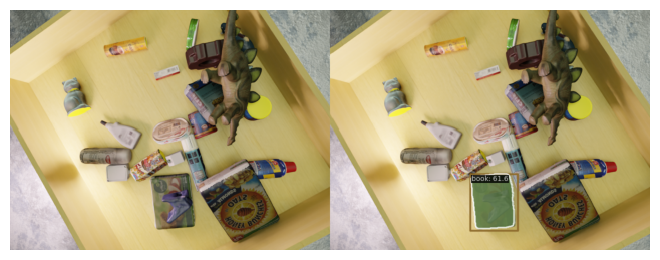

In [ ]:
# 결과 확인
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = True,
    wait_time=0,
    pred_score_thr=0.5
)
visualizer.show()


In [ ]:
del model

In [ ]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Config 파일을 설정하여 detector를 초기화합니다.
config_file = '/content/drive/MyDrive/gachon/mask-rcnn-config.py'
# 로드 할 체크포인트 파일 설정
checkpoint_file = '/content/drive/MyDrive/gachon/epoch_100.pth'

# MMDetection의 모든 모듈을 레지스트리에 등록
register_all_modules()

# Config 파일과 체크포인트 파일을 불러와 모델을 빌드
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'

Loads checkpoint by local backend from path: /content/drive/MyDrive/gachon/epoch_100.pth


In [ ]:
from mmdet.registry import VISUALIZERS
# visualizer 초기화(블록을 한 번만 실행할 것)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# 체크포인트에서 dataset_meta가 로드되고 를 init_detector의 모델에 전달.
visualizer.dataset_meta = model.dataset_meta

model.dataset_meta

{'classes': ('unoccluded', 'occluded'),
 'palette': [(220, 20, 60),
  (119, 11, 32),
  (0, 0, 142),
  (0, 0, 230),
  (106, 0, 228),
  (0, 60, 100),
  (0, 80, 100),
  (0, 0, 70),
  (0, 0, 192),
  (250, 170, 30),
  (100, 170, 30),
  (220, 220, 0),
  (175, 116, 175),
  (250, 0, 30),
  (165, 42, 42),
  (255, 77, 255),
  (0, 226, 252),
  (182, 182, 255),
  (0, 82, 0),
  (120, 166, 157),
  (110, 76, 0),
  (174, 57, 255),
  (199, 100, 0),
  (72, 0, 118),
  (255, 179, 240),
  (0, 125, 92),
  (209, 0, 151),
  (188, 208, 182),
  (0, 220, 176),
  (255, 99, 164),
  (92, 0, 73),
  (133, 129, 255),
  (78, 180, 255),
  (0, 228, 0),
  (174, 255, 243),
  (45, 89, 255),
  (134, 134, 103),
  (145, 148, 174),
  (255, 208, 186),
  (197, 226, 255),
  (171, 134, 1),
  (109, 63, 54),
  (207, 138, 255),
  (151, 0, 95),
  (9, 80, 61),
  (84, 105, 51),
  (74, 65, 105),
  (166, 196, 102),
  (208, 195, 210),
  (255, 109, 65),
  (0, 143, 149),
  (179, 0, 194),
  (209, 99, 106),
  (5, 121, 0),
  (227, 255, 205),
  (

In [ ]:
# detector를 사용하여 추론 수행
image = mmcv.imread('./drive/MyDrive/gachon/val/1050.png', channel_order='rgb')
result = inference_detector(model, image)

result

<DetDataSample(

    META INFORMATION
    img_shape: (800, 1067)
    scale_factor: (1.6671875, 1.6666666666666667)
    ori_shape: (480, 640)
    pad_shape: (800, 1088)
    img_id: 0
    img_path: None
    batch_input_shape: (800, 1088)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([], device='cuda:0', size=(0, 4))
            masks: PolygonMasks(num_masks=0, height=480, width=640)
            labels: tensor([], device='cuda:0', dtype=torch.int64)
        ) at 0x7a33957cbe20>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([[354.2063, 203.7278, 413.1760, 258.4192],
                        [105.4102, 138.5298, 163.4742, 218.4729],
                        [240.7361, 276.6630, 316.3096, 345.5981],
                        [370.9178, 298.6737, 536.7328, 465.1318],
                        [139.3576, 275.

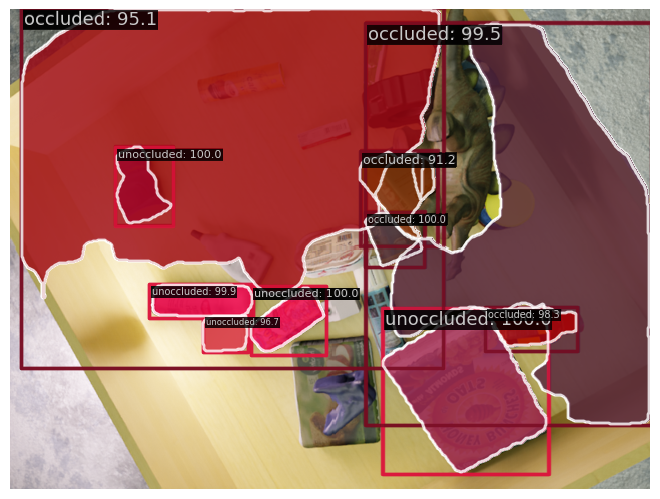

In [ ]:
# 결과 확인
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = False,
    wait_time=0,
    pred_score_thr=0.9
)
visualizer.show()


In [ ]:
from mmengine import Config
cfg = Config.fromfile('/content/drive/MyDrive/gachon/mask-rcnn-config.py')

print(cfg.pretty_text)

auto_scale_lr = dict(base_batch_size=16, enable=False)
backend_args = None
data_root = '/workspace/docker_share/datasets/dataset_piecepicking_0829/'
dataset_type = 'CocoDataset'
default_hooks = dict(
    checkpoint=dict(interval=1, type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
launcher = 'none'
load_from = '/workspace/mmdetection/work_dirs/mask-rcnn_r50_fpn_ms-poly-3x_coco/epoch_12.pth'
log_level = 'INFO'
log_processor = dict(by_epoch=True, type='LogProcessor', window_size=50)
model = dict(
    backbone=dict(
        depth=50,
        frozen_stages=1,
        init_cfg=dict(checkpoint='torchvision://resnet5

In [ ]:
from mmengine.runner import set_random_seed

cfg.metainfo = {
    'classes': ('unoccluded', 'occluded',),
    'palette': [
        (220, 20, 60),
        (35, 235, 195),
    ]
}

# dataset의 경로를 설정합니다.
cfg.data_root = '/content/drive/MyDrive/gachon'

cfg.train_dataloader.dataset.dataset.ann_file = 'annotations/train_data.json'
cfg.train_dataloader.dataset.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'annotations/val_data.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'train/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# validation에 필요한 annotation 경로를 추가합니다.
cfg.val_evaluator.ann_file = cfg.data_root + '/annotations/val_data.json'
cfg.test_evaluator = cfg.val_evaluator

# 클래스 개수를 설정합니다. COCO Dataset은 2개의 클래스를 학습합니다.
cfg.model.roi_head.bbox_head.num_classes = 2
cfg.model.roi_head.mask_head.num_classes = 2

# 빠르게 학습하기 위해 기존에 학습되어 있는 모델을 불러와 Fine-tune을 합니다.
cfg.load_from = '/content/checkpoints/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'

# 모델의 가중치, 최종 config 파일 및 log를 저장할 디렉토리를 설정합니다.
cfg.work_dir = './tutorial_exps'

cfg.train_cfg.max_iters = 1000000
# validation의 주기를 설정합니다.
cfg.train_cfg.val_interval = 100
# 학습된 가중치 저장 주기를 설정합니다.
cfg.default_hooks.checkpoint.interval = 100

# 기본이 8개의 GPU에 학습되는 것으로 세팅되어 있기 때문에
# 1개의 GPU를 사용하는 환경에서의 lr을 줄여줍니다.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10

# 일관된 학습 상태를 유지하기 위해 seed를 고정합니다.
# cfg.seed = 0
set_random_seed(0, deterministic=False)


0

In [ ]:
from mmengine.runner import Runner
cfg.resume = False
# config를 통해 runner를 빌드함
runner = Runner.from_cfg(cfg)

10/12 12:30:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
    CUDA available: True
    numpy_random_seed: 209652396
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50

In [ ]:
# 학습을 시작합니다.
runner.train()

loading annotations into memory...
Done (t=1.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
10/12 12:26:23 - mmengine - INFO - load model from: torchvision://resnet50
10/12 12:26:23 - mmengine - INFO - Loads checkpoint by torchvision backend from path: torchvision://resnet50
10/12 12:26:23 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: /content/drive/MyDrive/gachon/epoch_100.pth
10/12 12:26:25 - mmengine - INFO - Load checkpoint from /content/drive/MyDrive/gachon/epoch_100.pth
10/12 12:26:25 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/12 12:26:25 - mmengine - INFO - Checkpoints will be 